# Exercício: ReAct

Elton Cardoso do Nascimento, 233840

Enunciado:

- Implementar a ReAct  com LLaMa 3 70B (groq) `→Implementado`
- Testar no dataset do IIRC - 50 primeiras perguntas com resposta (test_questions.json em anexo) `→Arquivo não utilizado pois não tem todos os documentos relacionados as perguntas`
- Usar o prompt do LLaMAIndex: https://github.com/run-llama/llama_index/blob/a87b63fce3cc3d24dc71ae170a8d431440025565/llama_index/agent/react/prompts.py `→Prompt semelhante utilizado`
- Salvar as respostas finais das 50 perguntas no JSON para exercício futuro de avaliação `→[Arquivo JSON](https://github.com/EltonCN/IA024-NLP/blob/main/10-ReAct/results.json) salvo`
- Instruir o modelo a seguir a sequência Thougth, Action, Input, Observation (a observação não é do próprio modelo, mas resultado da busca) `→Sequência possível, mas permitindo ao modelo escolher qual será a próxima etapa`
- É necessário usar o parâmetro stop_sequence="Observation:", para o modelo parar de gerar texto e esperar o retorno da busca. Implementem o código da busca e retornem os top-k documentos pro modelo (sugestão: k=5). `→Código de busca implementado. Parâmetro de parada não foi necessário`
- Instruir o modelo agir passo-a-passo (decomposição da pergunta). `→Modelo age passo-a-passo, mas sem necessariamente decompor a pergunta`
- Podem usar o LangChain, LLaMAindex ou outro framework. Ou implementar na mão. `→Implementado na mão`
- Usar a busca como ferramenta `→Implementado`
- Usar o BM25 como buscador (repetir indexação do exercício passado) `→BM25 utilizado`
- Usar a indexação do Visconde: https://github.com/neuralmind-ai/visconde/blob/main/iirc_create_indices.ipynb `→Indexação do Visconde utilizada`

Iremos começar importanto todos os módulos que serão utilizados nesta atividade:

In [39]:
import os #Operações com o SO (arquivos)
import json #Leitura/escrita de arquivos JSON
import time #Sleep
import threading #Multithreading
import unicodedata #Normalização de string
import collections #Estrutura de contador e fila
import string #Operações com strings
import re #Expressões regulares
import abc #Classes abstratas
import warnings #Lançamento de warnings
from typing import Optional, Dict, Tuple, Any #Type hints

import torch #spacy não carrega sem importar antes (??)
import spacy #Separador em sentenças
import tqdm #Barra de progresso
import groq #API para o Llama 3 70B
from pyserini.search import SimpleSearcher #Busca nos documentos
import sentence_transformers #Rerankeamento
import bs4 #Remoção de tags HTML
import numpy as np #Operações com arrays
import matplotlib.pyplot as plt #Plots

## Preparação dos dados

Antes de começar a implementação em si, precisamos preparar os dados que serão utilizados. O código desta seção é principalmente uma modificação do código do [Visconde](https://github.com/neuralmind-ai/visconde/).

Começamos pelo download e leitura dos dados:

In [2]:
if not os.path.isdir("data"):
    os.mkdir("data")

if not os.path.isfile("data\\context_articles.json"):
    !curl -LO https://iirc-dataset.s3.us-west-2.amazonaws.com/context_articles.tar.gz
    !move context_articles.tar.gz data
    !tar -xf data/context_articles.tar.gz
    !move context_articles.json data

if not os.path.isfile("data\\iirc_test.json"):
    !curl -LO https://iirc-dataset.s3.us-west-2.amazonaws.com/iirc_test.json
    !move iirc_test.json data

In [2]:
file = open("data\\context_articles.json", "r")
articles = json.load(file)
file.close()

In [3]:
file = open("data\\iirc_test.json", "r")
test_data = json.load(file)
file.close()

E partimos para a extração das perguntas, respostas e documentos que serão utilizados.

(menção ao [@fabiograssiotto](https://github.com/fabiograssiotto/IA024/blob/main/Aula_9_10/RA890441%20-%20Aula9_10.ipynb) pelo código para remoção de tags HTML)

In [40]:
n_question = 50

In [5]:
questions = []
documents_titles = set()
documents = []
documents_not_found = set()

for i in range(len(test_data)):
    item = test_data[i]

    #Get the main document
    name = item['title'].lower()
    if name not in documents_titles:
        text = item["text"]
        soup = bs4.BeautifulSoup(text, "html.parser")
        clean_text = soup.get_text()

        document = {
                    "title": item['title'],
                    "content": clean_text
                }
        
        documents.append(document)
        documents_titles |= {name}

    #Get the documents
    for link in item["links"]:
        name : str = link['target'].lower()
        if name in articles and name not in documents_titles:
            text = articles[link['target'].lower()]
            soup = bs4.BeautifulSoup(text, "html.parser")
            clean_text = soup.get_text()
            
            document = {
                "title": link['target'],
                "content": clean_text
            }

            documents.append(document)
            documents_titles |= {name}
        
        else:
            documents_not_found |= {name}

    #Get the questions
    for q in item["questions"]:
        question = {}
        
        #Get and format the answer
        if q["answer"]["type"] == "span":
            question["answer"] = q["answer"]["answer_spans"][0]["text"]
        elif q["answer"]["type"] == "value":
            question["answer"] = q["answer"]["answer_value"]+" "+q["answer"]["answer_unit"]
        elif  q["answer"]["type"] == "none":
            continue
        elif q["answer"]["type"] == "binary":
            question["answer"] = q["answer"]["answer_value"]
        else:
            raise ValueError
        
        question["question"] = q["question"]

        questions.append(question)

        if len(questions) == n_question:
            break
    if len(questions) == n_question:
            break


In [7]:
len(documents_not_found), len(documents)

(17, 419)

E extraímos sentenças dos documentos:

In [8]:
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

#12345
#   45678
stride = 3#2
max_length = 5#3

def window(documents, stride, max_length):
    treated_documents = []

    for j,document in enumerate(tqdm.tqdm(documents)):
        doc_text = document['content']
        doc = nlp(doc_text[:10000])
        sentences = [sent.text.strip() for sent in doc.sents]
        for i in range(0, len(sentences), stride):
            segment = ' '.join(sentences[i:i + max_length])
            treated_documents.append({
                "title": document['title'],
                "contents": document['title']+". "+segment,
                "segment": segment
            })
            if i + max_length >= len(sentences):
                break
    return treated_documents

treated_documents = window(documents, stride, max_length)

100%|██████████| 419/419 [00:03<00:00, 129.78it/s]


Escrevemos os documentos em um arquivo JSONL e criamos o índice:

In [9]:
if not os.path.isdir("data\iirc_indices"):
    !mkdir data\iirc_indices

In [10]:
file = open("data/iirc_indices/contents.jsonl",'w')

for i, doc in enumerate(treated_documents):
    doc['id'] = i
    if doc['segment'] != "":
        file.write(json.dumps(doc)+"\n")

In [11]:
!python -m pyserini.index -collection JsonCollection -generator DefaultLuceneDocumentGenerator -threads 1 -input data/iirc_indices -index data/iirc_index -storeRaw

pyserini.index is deprecated, please use pyserini.index.lucene.
2024-05-14 15:05:18,277 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2024-05-14 15:05:18,280 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2024-05-14 15:05:18,280 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2024-05-14 15:05:18,280 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: data/iirc_indices
2024-05-14 15:05:18,280 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2024-05-14 15:05:18,281 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2024-05-14 15:05:18,281 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 1
2024-05-14 15:05:18,281 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: en


In [6]:
index_path = "./data/iirc_index"

## Groq API

Uma classe base é definida para uso da API do Groq:

In [7]:
class GroqInterface:
    '''
    Interface for using the Groq API

    Implements a rate limit control for multi-threading use. 
    '''

    _client :groq.Groq = None 

    LLAMA3_70B = "llama3-70b-8192"

    inference_lock = threading.Lock()
    time_waiter_lock = threading.Lock()
    SINGLE_THREAD = True

    def __init__(self, model:Optional[str]=None, api_key:Optional[str]=None, json_mode:bool=False, system_message:Optional[str]=None, n_retry:int=5):
        '''
        GroqInterface constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
            api_key (str, optional): Groq API key to use, if None will check the environment 'GROQ_API_KEY' variable. Default is None.
            json_mode (bool): if the model need to output in JSON. Default is False.
            system_message (str): the system message to send to the model, if needed. Default is None.
            n_retyr (int): number of times to retry if the model fails (not considering RateLimitError). Default is 5.
        '''
        
        if GroqInterface._client is None:

            if api_key is None:
                api_key = os.environ.get("GROQ_API_KEY")

            if api_key is None:
                raise RuntimeError("API key is not in the environment variables ('GROQ_API_KEY' variable is not set).")

            GroqInterface._client = groq.Groq(api_key=api_key)

        if model is None:
            model = GroqInterface.LLAMA3_70B
        self._model = model

        self._system_message = system_message


        if json_mode:
            self._response_format = {"type": "json_object"}
        else:
            self._response_format = None
        self._json_mode = json_mode

        self._n_retry = n_retry

    def __call__(self, prompt:str) -> str:
        '''
        Generates the model response

        Args:
            prompt (str): prompt to send to the model.

        Returns:
            str: model response. 
        '''
        done = False
        retry_count = 0
        while not done:
            try:
                if not GroqInterface.SINGLE_THREAD:
                    GroqInterface.inference_lock.acquire()
                    GroqInterface.inference_lock.release()

                messages = []
                if self._system_message is not None:
                    messages.append({"role":"system", "content":self._system_message})
                
                messages.append({"role":"user", "content":prompt})

                chat_completion = GroqInterface._client.chat.completions.create(
                        messages=messages,
                        model=self._model,
                        response_format=self._response_format
                    )
                
                done = True
            except groq.RateLimitError as exception: #Wait
                print("ERROR")
                print(exception)
                
                GroqInterface.error = exception
                if not GroqInterface.SINGLE_THREAD:
                    if not GroqInterface.time_waiter_lock.locked():
                        GroqInterface.time_waiter_lock.acquire()
                        GroqInterface.inference_lock.acquire()
                        time.sleep(2)
                        GroqInterface.time_waiter_lock.release()
                        GroqInterface.inference_lock.release()
                else:
                    time.sleep(2)

            except KeyboardInterrupt as e: #Stop the code
                raise e
            except Exception as e: #Retry
                retry_count += 1
                if retry_count >= self._n_retry:
                    raise e

        return chat_completion.choices[0].message.content

In [8]:
groq_interface = GroqInterface()

In [15]:
groq_interface("Hi!")

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

## Métrica

Três métricas serão definidas para avaliar o modelo:

- Corretude (acurácia): se a resposta está correta. Estimado utilizando o próprio modelo comparando com a resposta correta.
- F1 score
- Resposta idêntica 

In [ ]:
class GroqAnswerEvaluator(GroqInterface):
    """
    Evaluates if a answer is correct, comparing with the correct answer.
    """

    _system_message = '''You are a answer comparator that outputs in JSON. 
The JSON object must use the schema: {'is_correct':'bool'}
Please use a valid JSON format.'''

    _base_prompt = '''Is the second answer correct, comparing to the first one? 
First answer: {answer_correct}
Second answer: {answer} 
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str]=None):
        '''
        GroqAnswerEvaluator constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
            api_key (str, optional): Groq API key to use, if None will check the environment 'GROQ_API_KEY' variable. Default is None.
        '''

        super().__init__(model, api_key, True, GroqAnswerEvaluator._system_message)

    def __call__(self, answer_correct:str, answer:str) -> bool:
        '''
        Checks if the answer is correct

        Args:
            answer_correct (str): correct answer to compare.
            answer (str): answer to evaluate.

        Returns:
            bool: True if is correct.
        '''

        prompt = GroqAnswerEvaluator._base_prompt.format(answer_correct=answer_correct, answer=answer)

        response = super().__call__(prompt)
        response = json.loads(response)

        return response["is_correct"]

In [ ]:
def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  def remove_accents(input_str):
      nfkd_form = unicodedata.normalize('NFKD', input_str)
      only_ascii = nfkd_form.encode('ASCII', 'ignore')
      return only_ascii.decode("utf-8")

  return white_space_fix(remove_articles(remove_punc(lower(remove_accents(s)))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

Checamos o funcionamento das avaliações com um conjunto de resposta modelo, correta e errada:

In [10]:
#Question is "What is Zeus know for in Greek mythology?"

a_gold = "sky and thunder god"
a_correct = "Zeus is known as the king of the gods and the god of the sky and thunder in Greek mythology." #Correct and contains the expected answer 
a_wrong = "Zeus is been depicted as using violence to get his way and terrorize humans." #±Correct, but not related to the expected answer

In [11]:
groq_corrector = GroqAnswerEvaluator()

In [19]:
groq_corrector(a_gold, a_correct), groq_corrector(a_gold, a_wrong),

(True, False)

In [21]:
compute_f1(a_gold, a_correct), compute_exact(a_gold, a_correct)

(0.4, 0)

In [22]:
compute_f1(a_gold, a_wrong), compute_exact(a_gold, a_wrong)

(0.11111111111111112, 0)

## Implementação do ReAct 

E podemos começar a implementação do ReAct. Ela é dividida entre a implementação das ferramentas que o agente terá disponível, e a implementação do código principal.

O código é próximo ao ReAct, mas diverge em alguns pontos na manutenção do contexto ("queries" não são mantidas) e uso das ferramentas ("think" e "answer" são considerados ferramentas).

### Ferramentas

As ferramentas implementadas são 
- "Search": busca a partir de uma query no banco de documentos
- "Answer": gera a resposta final
- "Think": reflete sobre o contexto até o momento
- "Routing": seleciona a próxima ferramenta a ser utilizada

In [13]:
class Tool(abc.ABC):
    '''
    Base class for creating LLM agent tools.
    '''

    @abc.abstractmethod
    def __call__(self, query:str, context:str) -> Dict[str, str]:
        '''
        Execute the tool.

        Args:
            query (str): query for the tool execution.
            context (str): agent context in the tool execution moment.

        Returns:
            Dict[str, str]: tool results.
        '''
        ...

A ferramenta de busca realiza uma busca inicial ampla nos documentos utilizando o BM25, e realiza um filtro e reranqueamento com um transformer:

In [14]:
class SearchTool(Tool):
    '''
    Search documents for some information.
    '''

    def __init__(self, index_path:str, embedder_model:str="all-MiniLM-L6-v2", search_k:int=20, rerank_k:int=5):
        '''
        SearchTool constructor.

        Args:
            index_path (str): path of the documents index.
            embedder_model (str, optional): model to use for reranking. Defaults to "all-MiniLM-L6-v2".
            search_k (int, optional): initial search size. Defaults to 20.
            rerank_k (int, optional): rerank filter size. Defaults to 5.
        '''
        self.embedder = sentence_transformers.SentenceTransformer(embedder_model)
        self.searcher = SimpleSearcher(index_path)

        if search_k < rerank_k:
            warnings.warn(f"search_k is less than rerank_k. The result will be of search_k size. ({search_k} < {rerank_k})")
        
        self.search_k = search_k
        self.rerank_k = rerank_k
    
    def __call__(self, query:str, context:Optional[Any]=None) -> Dict[str, str]:
        '''
        Execute a search.

        Args:
            query (str): search term
            context (Any, optional): not used. Defaults to None.

        Returns:
            Dict[str, str]: search result. Have only the key "result" with the search result.
        '''

        
        #Initial search
        search_result = self.searcher.search(query, k=self.search_k)
        
        #Get documents
        search_docs = []
        for result in search_result:
            result = json.loads(result.raw)

            search_docs.append(result["segment"])

        #Rerank and filter
        query_embedding = self.embedder.encode(query, convert_to_tensor=True)
        search_embeddings = self.embedder.encode(search_docs, convert_to_tensor=True)

        rerank_result = sentence_transformers.util.semantic_search(query_embedding, search_embeddings, top_k=self.rerank_k)

        #Generate response with the selected documents
        response = ""
        for result in rerank_result[0]:
            index = result["corpus_id"]
            result_doc = search_docs[index]

            response += result_doc + "\n"
        
        response = {"result":response}


        return response

In [15]:
class AnswerTool(Tool, GroqInterface):
    '''
    Generates the final answer to a question.
    '''


    _system_message = '''You are a question answerer that outputs in JSON. 
The JSON object must use the schema: {'answer':'str'}
Please use a valid JSON format.'''

    _base_prompt = '''{context}

Considering all this context, provide the FINAL ANSWER to the question:
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):
        '''
        AnswerTool constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
            api_key (str, optional): Groq API key to use, if None will check the environment 'GROQ_API_KEY' variable. Default is None.
        '''

        super().__init__(model, api_key, True, AnswerTool._system_message)

    def __call__(self, query:Optional[Any]=None, context:str=None) -> Dict[str, str]:
        '''
        Answers a question considering the agent context.

        Args:
            query (Optional[Any], optional): not used. Defaults to None.
            context (str): context of the agent, must contain the question.

        Returns:
            Dict[str, str]: agent response. Contains only the key "answer" with the answer.
        '''
        
        
        prompt = AnswerTool._base_prompt.format(context=context)

        return json.loads(GroqInterface.__call__(self, prompt=prompt))

In [16]:
class ThinkTool(Tool, GroqInterface):
    '''
    Reflects about the agent context.
    '''

    _system_message = '''You are responsible for reflecting on provided information, and outputs in JSON. 
The JSON object must use the schema: {'reflection':'str'}
Please use a valid JSON format.'''

    _base_prompt = '''{context}

Considering all this context, provide a useful reflection.
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):
        '''
        ThinkTool constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
            api_key (str, optional): Groq API key to use, if None will check the environment 'GROQ_API_KEY' variable. Default is None.
        '''

        super().__init__(model, api_key, True, ThinkTool._system_message)

    def __call__(self, query:Optional[Any]=None, context: str=None) -> Dict[str, str]:
        '''
        Think about the agent context, generating a useful reflection.

        Args:
            query (Optional[Any], optional): not used. Defaults to None.
            context (str): agent context to reflect about. Defaults to None.

        Returns:
            Dict[str, str]: tool result. Contains only the key "reflection" with the reflection.
        '''

        prompt = ThinkTool._base_prompt.format(context=context)

        return json.loads(GroqInterface.__call__(self, prompt=prompt))    

In [17]:
class RoutingTool(Tool, GroqInterface):
    '''
    Selects the next agent tool.
    '''


    _system_message = '''You are a tool selector that outputs in JSON.
For each selection, you must provide a throught about the previous content and why you are selecting this tool.

You have available the following tools:

Name: 'search'
Query content: the sentence to search
Tool description: it searchs for documents with possible usefull information using the query.

Name: 'answer'
Query content: empty (''), is not used.
Tool description: considering the previous content, provides the final answer for the question.

Name: 'think'
Query content: empty (''), is not used;
Tool descripting: considering the previous content, generates a useful reflection.

The JSON object must use the schema: {'throught':'str',
'tool_name':'str',
'query':'str'}

Please use a valid JSON format.'''

    _base_prompt = '''{context}
    
Considering all this context, select the next tool to use:
    '''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):
        '''
        RoutingTool constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
            api_key (str, optional): Groq API key to use, if None will check the environment 'GROQ_API_KEY' variable. Default is None.
        '''

        super().__init__(model, api_key, True, RoutingTool._system_message)

    def __call__(self, query:Optional[Any]=None, context:str=None) -> Dict[str, str]:
        '''
        Select the next tool for the agent.

        Args:
            query (Optional[Any], optional): not used. Defaults to None.
            context (str, optional): agent context to decide the next tool. Defaults to None.

        Returns:
            Dict[str, str]: tool result. Have the keys 'tool_name' (next tool to use), 
                'throught' (why use this tool), 'query' (query to send to the tool).
        '''
        prompt = RoutingTool._base_prompt.format(context=context)

        return json.loads(GroqInterface.__call__(self, prompt=prompt))

Para testar as ferramentas, vamos executar passo a passo um processo de resposta, chamando manualmente o código necessário e compondo o contexto. Observe que, pela re-execução do notebook, algumas sentenças nos contextos montados podem não coincidir exatamente com a resposta do modelo.

Começamos pela definição da questão e criação das ferramentas:

In [23]:
test_question = "What is Zeus know for in Greek mythology?"

In [18]:
search_tool = SearchTool(index_path)


SimpleSearcher class has been deprecated, please use LuceneSearcher from pyserini.search.lucene instead


In [19]:
answer_tool = AnswerTool()
think_tool = ThinkTool()

routing_tool = RoutingTool()

O contexto inicial contém apenas a questão, e é utilizado para selecionar a primeira ferramenta (não considerando a ferramenta de roteamento que sempre é utilizada entre as outras):

In [30]:
test_context = f'''Question: {test_question}'''

routing_tool(context=test_context)

{'thought': 'The user has asked a question about Greek mythology, I need to find relevant information.',
 'tool_name': 'search',
 'query': 'What is Zeus known for in Greek mythology?'}

A ferramenta de busca foi selecionada. Vamos executar a busca:

In [31]:
search_result = search_tool("Zeus Greek mythology", "")

In [43]:
print(search_result["result"])

Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion, who rules as king of the gods of Mount Olympus. His name is cognate with the first element of his Roman equivalent Jupiter. His mythologies and powers are similar, though not identical, to those of Indo-European deities such as Jupiter, Perkūnas, Perun, Indra and Thor. Zeus is the child of Cronus and Rhea, the youngest of his siblings to be born, though sometimes reckoned the eldest as the others required disgorging from Cronus's stomach. In most traditions, he is married to Hera, by whom he is usually said to have fathered Ares, Hebe, and Hephaestus.
Since lightning is quite powerful and sometimes deadly, it is a bold sign when lightning strikes because it is known that Zeus most likely threw the bolt. In the Iliad. The Iliad is a poem by Homer about the Trojan war and the battle over the City of Troy, in which Zeus plays a major part. Scenes in which Zeus appears include:



Compor o novo contexto e selecionar a próxima ferramenta:

In [32]:
test_context2 = f'''
Question: {test_question}

Thought: I need to search for information about Zeus in Greek mythology to find the answer.
Search result: {search_result["result"]}
'''

routing_tool(context=test_context2)

{'thought': 'Now that I have searched and found information about Zeus in Greek mythology, I can reflect on the key points to understand the essence of his character and significance.',
 'tool_name': 'think',
 'query': ''}

Executamos a ferramenta de pensamento:

In [33]:
test_context3 = f'''
Question: {test_question}

Thought: I need to search for information about Zeus in Greek mythology to find the answer.
Search result: {search_result["result"]}

Thought: I have gathered information about Zeus in Greek mythology, now I need to think about the context to understand the main points and reflect on the answer.
'''

think_tool(context=test_context3)

{'reflection': "Zeus, in Greek mythology, is the king of the gods, known for being the sky and thunder god, ruling from Mount Olympus. He wields significant power, controlling the weather and fate of humans, often using his lightning bolts to intervene in mortal affairs. Throughout literature, such as in Homer's Iliad, Zeus plays a major role, influencing the war and its outcome. His character is multifaceted, displaying emotions, making decisions, and interacting with other gods and mortals. His power and influence are undeniable, making him a central figure in Greek mythology."}

Próximo roteamento:

In [34]:
test_context4 = f'''
Question: {test_question}

Thought: I need to search for information about Zeus in Greek mythology to find the answer.
Search result: {search_result["result"]}

Thought: I have gathered information about Zeus in Greek mythology, now I need to think about the context to understand the main points and reflect on the answer.
Think result: Zeus is known as the sky and thunder god in ancient Greek religion and is often depicted holding a thunderbolt. He is the king of the gods and is married to Hera, with whom he has fathered several children. His powers and mythologies are similar to those of other Indo-European deities, such as Jupiter in Roman mythology. He is often depicted in art standing or seated in majesty, holding a scepter, and is associated with the eagle, bull, and oak."
'''

routing_tool(context=test_context4)

{'thought': 'I have thought about the context and I think it is time to answer the question.',
 'tool_name': 'answer',
 'query': ''}

E chamamos por fim a ferramenta de resposta:

In [35]:
test_context5 = f'''
Question: {test_question}

Thought: I need to search for information about Zeus in Greek mythology to find the answer.
Search result: {search_result["result"]}

Thought: I have gathered information about Zeus in Greek mythology, now I need to think about the context to understand the main points and reflect on the answer.
Think result: Zeus is known as the sky and thunder god in ancient Greek religion, and is the king of the gods of Mount Olympus.

Thought: "I\'ve reflected on the information and main points about Zeus, now I need to provide a concise answer to the original question."
'''

answer_tool(context=test_context5)

{'answer': 'Zeus is known as the sky and thunder god in ancient Greek religion, and is the king of the gods of Mount Olympus.'}

### Código principal

O código principal tem como função utilizar as ferramentas para responder questões, compondo o contexto com os resultados delas:

In [19]:
class QuestionAnswerer:
    '''
    Answers a question using a LLM agent.
    '''

    def __init__(self, search_tool:SearchTool, routing_tool:Optional[RoutingTool]=None, 
                 think_tool:Optional[ThinkTool]=None, answer_tool:Optional[AnswerTool]=None ) -> None:
        '''
        QuestionAnswerer constructor.

        Args:
            search_tool (SearchTool): search tool for the agent.
            routing_tool (Optional[RoutingTool], optional): routing tool for the agent. If None creates a new with default arguments. Defaults to None.
            think_tool (Optional[ThinkTool], optional): think tool for the agent. If None creates a new with default arguments. Defaults to None.
            answer_tool (Optional[AnswerTool], optional): answer tool for the agent. If None creates a new with default arguments. Defaults to None.
        '''
        
        self._search_tool = search_tool

        if routing_tool is None:
            routing_tool = RoutingTool()

        if think_tool is None:
            think_tool = ThinkTool()

        if answer_tool is None:
            answer_tool = AnswerTool()

        self._routing_tool = routing_tool
        self._think_tool = think_tool
        self._answer_tool = answer_tool

        
    def __call__(self, question:str, max_steps:int = 5, verbose=False) -> Tuple[str, str, str]:
        '''
        Answers a question using the agent.

        Args:
            question (str): question to answer.
            max_steps (int, optional): maximum number of tools use, the last one is always "AnswerTool". Defaults to 5.
            verbose (bool, optional): if should print the tool sequence while executing. Defaults to False.

        Returns:
            str: answer for the question.
            str: resulting context used to answer.
            str: sequence of used tools.
        '''

        context = f"Question: {question}"
        tool_sequence = ""

        step = 0

        while True:
            
            if step >= max_steps-1: #Max steps -> force answer
                next_tool = "answer"
                query = ""
                thought = "Now I need to provide a concise answer to the original question."
            else: #Select next tool with the routing tool
                if verbose:
                    print("R", end="")
                tool_sequence += "R"

                rounting_result = self._routing_tool(context=context)
                next_tool = rounting_result["tool_name"].lower()
                query = rounting_result["query"]
                thought = rounting_result["thought"]

            #Compose context with the reasoning about the tool usage
            context += f"\n\nThought: {thought}\n"

            if verbose:
                print(next_tool[0].upper(), end="")
            tool_sequence += next_tool[0].upper()

            try:
                
                #Use the selected tool
                if next_tool == "search":
                    search_result = self._search_tool(query=query, context=context)
                    context += f"Search result: {search_result['result']}"
                elif next_tool == "think":
                    think_result = self._think_tool(query=query, context=context)
                    context += f"Think result: {think_result['reflection']}"
                elif next_tool == "answer":
                    answer_result = self._answer_tool(query=query, context=context)

                    if verbose:
                        print("")
                    
                    #Answer tool ends the execution
                    return answer_result["answer"], context, tool_sequence
                
            except KeyboardInterrupt as e:
                raise e
            
            except:
                if verbose:
                    print("F", end="\n")
                
                tool_sequence += "F"
                context += "The tool failed. I can try using it again, or try using another tool."
                
            
            step += 1

Testamos o agente com a mesma questão utilizada anteriormente:

In [20]:
question_answerer = QuestionAnswerer(search_tool)

In [26]:
answer, context, tool_sequence = question_answerer(test_question, verbose=True)

RSRTRA


In [27]:
answer

"Zeus, in Greek mythology, is the king of the gods and the god of the sky and thunder. He is known for wielding powerful lightning bolts and is depicted in various poses in art, often with his symbols, the thunderbolt, eagle, bull, or oak. He is married to Hera and has fathered several children, including Ares, Hebe, and Hephaestus. Zeus plays a significant role in Homer's Iliad, influencing the outcome of the Trojan War."

In [28]:
print(context)

Question: What is Zeus know for in Greek mythology?

Thought: I want to find relevant information about Zeus in Greek mythology, so I choose a tool that can search for related content.
Search result: Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion, who rules as king of the gods of Mount Olympus. His name is cognate with the first element of his Roman equivalent Jupiter. His mythologies and powers are similar, though not identical, to those of Indo-European deities such as Jupiter, Perkūnas, Perun, Indra and Thor. Zeus is the child of Cronus and Rhea, the youngest of his siblings to be born, though sometimes reckoned the eldest as the others required disgorging from Cronus's stomach. In most traditions, he is married to Hera, by whom he is usually said to have fathered Ares, Hebe, and Hephaestus.
Since lightning is quite powerful and sometimes deadly, it is a bold sign when lightning strikes because it is known that Zeus mos

In [29]:
groq_corrector(a_gold, answer), compute_f1(a_gold, answer), compute_exact(a_gold, answer)

(True, 0.1142857142857143, 0)

In [30]:
tool_sequence

'RSRTRA'

## Geração das respostas

Aqui serão geradas as respostas de todas as perguntas de teste:

In [33]:
all_results = []
file = open ("results.jsonl", "w")

for i in tqdm.tqdm(range(n_question)):
    question = questions[i]["question"]
    gold_answer = questions[i]["answer"]

    try:
        answer, context, tool_sequence = question_answerer(question, verbose=True)

        is_correct = groq_corrector(gold_answer, answer)
        f1_score = compute_f1(gold_answer, answer)
        exact_score = compute_exact(gold_answer, answer)

    except KeyboardInterrupt as e:
        file.close()
        raise e
        
    except:
        answer = ""
        context = ""
        tool_sequence = "F"
        is_correct = False
        f1_score = 0
        exact_score = 0

    entry = {"question_number": i,
            "question":question,
             "gold_answer":gold_answer,
             "answer":answer,
             "tool_sequence":tool_sequence,
             "is_correct":is_correct,
             "f1_score":f1_score,
             "exact_score":exact_score,
             "context":context}
    
    all_results.append(entry)

    file.write(json.dumps(entry)+"\n")
    file.flush()

file.close()

  0%|          | 0/50 [00:00<?, ?it/s]

RSRTRA


  2%|▏         | 1/50 [00:35<28:57, 35.47s/it]

RSRTRA


  4%|▍         | 2/50 [01:21<33:15, 41.57s/it]

RSRA


  6%|▌         | 3/50 [01:44<25:50, 33.00s/it]

RSRTRA


  8%|▊         | 4/50 [02:28<28:53, 37.68s/it]

RSRTRA


 10%|█         | 5/50 [03:23<32:43, 43.63s/it]

RSRSRA


 12%|█▏        | 6/50 [04:08<32:25, 44.21s/it]

RSRA


 14%|█▍        | 7/50 [04:22<24:39, 34.41s/it]

RSRTRA


 16%|█▌        | 8/50 [05:25<30:24, 43.43s/it]

RSRSRA


 18%|█▊        | 9/50 [06:06<29:14, 42.80s/it]

RSRA


 20%|██        | 10/50 [06:24<23:21, 35.03s/it]

RSRA


 22%|██▏       | 11/50 [06:56<22:09, 34.10s/it]

RSRA


 24%|██▍       | 12/50 [07:14<18:34, 29.32s/it]

RSRTRA


 26%|██▌       | 13/50 [07:50<19:16, 31.25s/it]

RSRTRA


 28%|██▊       | 14/50 [08:34<21:01, 35.04s/it]

RSRA


 30%|███       | 15/50 [08:49<16:56, 29.05s/it]

RSRTRSRA


 32%|███▏      | 16/50 [10:08<25:00, 44.13s/it]

RSRTRSRA


 34%|███▍      | 17/50 [11:37<31:39, 57.57s/it]

RSRTRSR

 36%|███▌      | 18/50 [15:04<54:43, 102.61s/it]

ERROR
RSRTRA


 38%|███▊      | 19/50 [15:34<41:36, 80.53s/it] 

RSRTRA


 40%|████      | 20/50 [17:26<45:01, 90.04s/it]

RSRTRA


 42%|████▏     | 21/50 [18:38<40:54, 84.63s/it]

RSRTRA


 44%|████▍     | 22/50 [20:07<40:06, 85.96s/it]

RSRTRA


 46%|████▌     | 23/50 [21:15<36:17, 80.66s/it]

RSRA


 48%|████▊     | 24/50 [22:00<30:21, 70.06s/it]

RSRTRA


 50%|█████     | 25/50 [24:07<36:13, 86.94s/it]

RSRTRA


 52%|█████▏    | 26/50 [26:38<42:27, 106.14s/it]

RSRTRSRTA


 54%|█████▍    | 27/50 [29:37<49:06, 128.10s/it]

RSRTRSRSA


 56%|█████▌    | 28/50 [31:56<48:11, 131.45s/it]

RSRTRA


 58%|█████▊    | 29/50 [32:13<33:58, 97.05s/it] 

RSRTRA


 60%|██████    | 30/50 [32:59<27:16, 81.81s/it]

RSRA


 62%|██████▏   | 31/50 [33:25<20:31, 64.81s/it]

RSRTRA


 64%|██████▍   | 32/50 [34:10<17:44, 59.16s/it]

RSRTRA


 66%|██████▌   | 33/50 [35:01<16:04, 56.71s/it]

RSRTRA


 68%|██████▊   | 34/50 [35:43<13:52, 52.00s/it]

RSRA


 70%|███████   | 35/50 [35:55<10:04, 40.28s/it]

RSRTRSRA


 72%|███████▏  | 36/50 [37:41<13:59, 59.97s/it]

RSRA


 74%|███████▍  | 37/50 [38:05<10:39, 49.21s/it]

RSRTRA


 76%|███████▌  | 38/50 [39:01<10:13, 51.12s/it]

RSRTRA


 78%|███████▊  | 39/50 [39:42<08:49, 48.17s/it]

RSRA


 80%|████████  | 40/50 [40:04<06:41, 40.16s/it]

RSRA


 82%|████████▏ | 41/50 [40:28<05:17, 35.27s/it]

RSRA


 84%|████████▍ | 42/50 [40:51<04:14, 31.80s/it]

RSRTRA


 86%|████████▌ | 43/50 [41:22<03:41, 31.61s/it]

RSRA


 88%|████████▊ | 44/50 [41:43<02:50, 28.39s/it]

RSRTRSRTA


 90%|█████████ | 45/50 [43:32<04:22, 52.57s/it]

RSRA


 92%|█████████▏| 46/50 [43:54<02:52, 43.24s/it]

RSRA


 94%|█████████▍| 47/50 [44:15<01:50, 36.74s/it]

RSRTRA


 96%|█████████▌| 48/50 [44:51<01:13, 36.53s/it]

RSRTRA


 98%|█████████▊| 49/50 [45:30<00:37, 37.27s/it]

RSRTRA


100%|██████████| 50/50 [46:07<00:00, 55.35s/it]


46 min 7,5s

In [60]:
file = open("results.json", "w")
json.dump(all_results, file)
file.close()

## Avaliação

Com as respostas geradas, podemos avaliar a performance do agente.

In [5]:
file = open("results.json", "r")
all_results = json.load(file)
file.close()

Iniciamos pelo cálculo das métricas:

In [18]:
accuracy = 0.0
correctness = np.empty(n_question)
f1_scores = np.empty(n_question)
exact_scores = np.empty(n_question)
tool_sequences = []

for i in range(n_question):
    accuracy += all_results[i]["is_correct"]
    correctness[i] = all_results[i]["is_correct"]
    f1_scores[i] = all_results[i]["f1_score"]
    exact_scores[i] = all_results[i]["exact_score"]
    tool_sequences.append(all_results[i]["tool_sequence"])

accuracy /= n_question

print("Accuracy:", accuracy)
print("F1 score:", f1_scores.mean(), "±", f1_scores.std())
print("Exact score:", exact_scores.mean(), "±", exact_scores.std())

Accuracy: 0.52
F1 score: 0.47502661713188027 ± 0.45167093813665027
Exact score: 0.36 ± 0.48


Podemos verificar que o agente raramente tem uma resposta "meio correta" segundo o F1 score:

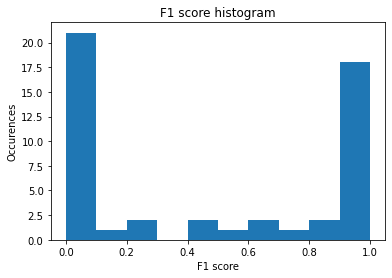

In [8]:
plt.hist(f1_scores)

plt.title("F1 score histogram")
plt.xlabel("F1 score")
plt.ylabel("Occurrences")

plt.show()

E que este score está de certa forma relacionado com a corretude da resposta, embora scores em aproximadamente (0.2, 0.6) sejam ambíguos sobre a corretude da resposta.

Text(0.5, 1.0, 'F1 score correctness')

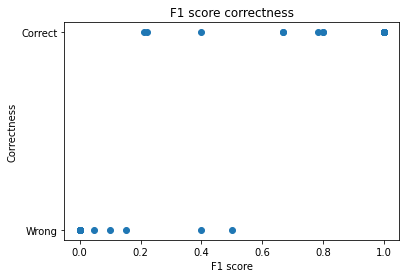

In [15]:
plt.plot(f1_scores, correctness, "o")

plt.xlabel("F1 score")

plt.yticks([0.0, 1.0], ["Wrong", "Correct"])
plt.ylabel("Correctness")

plt.title("F1 score correctness")

Já o score de resposta idêntica incorreta não indica necessariamente que a resposta está errada, enquanto que não possui nenhum falso positivo:

In [33]:
false_negative = np.bitwise_and(correctness == True, exact_scores == 0).sum()
false_positive = np.bitwise_and(correctness == False, exact_scores == 1).sum()
true_positive = np.bitwise_and(correctness == True, exact_scores == 1).sum()
true_negative = np.bitwise_and(correctness == False, exact_scores == 0).sum()

confusion_matrix = np.array([[true_positive, false_negative], [false_positive, true_negative]])

Text(0.5, 1.0, 'Correctness vs Exact')

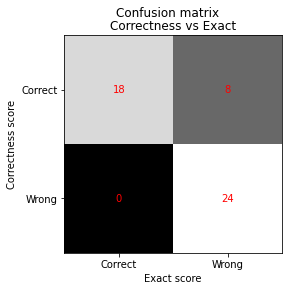

In [37]:
fig, ax = plt.subplots()

im = ax.imshow(confusion_matrix, cmap="Greys_r")

markers = ["Correct", "Wrong"]

ax.set_xticks(np.arange(len(markers)))
ax.set_yticks(np.arange(len(markers)))
ax.set_xticklabels(markers)
ax.set_yticklabels(markers)

plt.xlabel("Exact score")
plt.ylabel("Correctness score")

for i in range(len(markers)):
        for j in range(len(markers)):
            text = ax.text(j, i, np.around(confusion_matrix[i, j], decimals=2),
                        ha="center", va="center", color="red")
            
plt.suptitle("Confusion matrix")
plt.title("Correctness vs Exact")

Partimos agora para a análise das sequências de ferramentas

In [8]:
tool_sequences_unique, tool_sequences_count = np.unique(tool_sequences, return_counts=True)

Verificamos inicialmente que a sequência mais utilizada é realizar uma busca, pensamento e responder a questão, que era a sequência esperada pensando o funcionamento de cada ferramente: primeiro o agente procura informações sobre a pergunta, seguido por uma reflexão sobre essas informações e a resposta final.

A próxima sequência mais comum é pesquisar e responder, sem a etapa de pensamento, o que pode indicar que o agente considere desnecessário esta etapa, talvez pela resposta já estar clara nas informações encontradas.

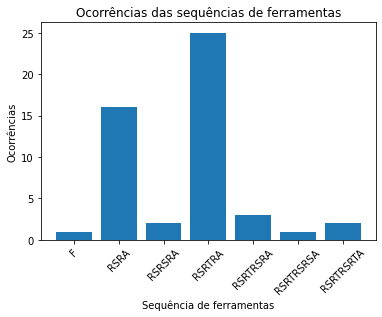

In [70]:
plt.bar(tool_sequences_unique, tool_sequences_count)
plt.xticks(rotation=45)

plt.title("Ocorrências das sequências de ferramentas")
plt.xlabel("Sequência de ferramentas")
plt.ylabel("Ocorrências")

plt.show()

In [67]:
#Accuracy by tool

tool_sequences_accuracy = {}
for tool_sequence in tool_sequences_unique:
    tool_sequences_accuracy[tool_sequence] = 0

for result in all_results:
    tool_sequence = result["tool_sequence"]
    tool_sequences_accuracy[tool_sequence] += result["is_correct"]

tool_sequences_accuracy_list = []

for i in range(len(tool_sequences_unique)):
    tool_sequence = tool_sequences_unique[i]
    tool_sequences_accuracy[tool_sequence] /= tool_sequences_count[i]

    tool_sequences_accuracy_list.append(tool_sequences_accuracy[tool_sequence])

Já ao analisar a acurácia das ferramentas, podemos observar que a sequência "RSRSRA" é a mais acurada, onde o agente realiza duas buscas antes de gerar uma repostas. Comparando junto da sequência "RSRA", é perceptível que sequências que realizam pensamentos são menos acuradas, enquanto que ambas as duas sequências que estouraram o limite de ferramentas não geraram nenhuma resposta válida:

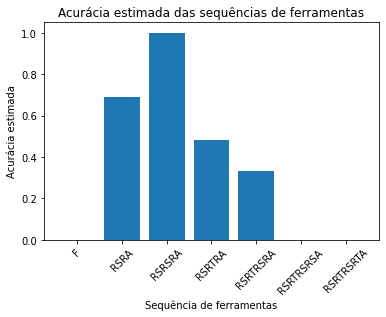

In [69]:
plt.bar(tool_sequences_unique, tool_sequences_accuracy_list)
plt.xticks(rotation=45)

plt.title("Acurácia estimada das sequências de ferramentas")
plt.xlabel("Sequência de ferramentas")
plt.ylabel("Acurácia estimada")

plt.show()

Geramos um grafo das ferramentas utilizadas:

In [11]:
#Tool graph generation

node_queue = collections.deque()
node_queue.append("")

next_tool_occurrences = {}
for t in ["R", "A", "T", "S", "F"]:
    next_tool_occurrences[t] = 0

adj_list = {}

while len(node_queue) != 0:
    current_node = node_queue.pop()

    if current_node in adj_list:
        continue


    total_occurrences = 0
    n_sequence = 0
    sequences = {}
    for i in range(len(tool_sequences_unique)):
        sequence = tool_sequences_unique[i]
        occurrences = tool_sequences_count[i]
        
        if len(sequence) > len(current_node):
            if sequence[:len(current_node)] != current_node:
                continue
            
            next_char = sequence[len(current_node)]

            total_occurrences += occurrences
            next_tool_occurrences[next_char] += occurrences

            if next_char in sequences:
                sequences[next_char] += occurrences
                
            else:
                sequences[next_char] = occurrences

                if current_node+next_char not in node_queue:
                    node_queue.append(current_node+next_char)

    

    for sequence in sequences:
        sequences[sequence] /= total_occurrences
    adj_list[current_node] = sequences
        


In [123]:
#Print of the graph

print("flowchart LR")

for node in adj_list:
    for next_char in adj_list[node]:
        node_to_print = node

        if node_to_print == "":
            node_to_print = "''"

        probability = adj_list[node][next_char]
        probability *= 100
        probability = round(probability, 2)

        if int(probability) == probability:
            probability = int(probability)

        next_node = node+next_char
        print(f"{node_to_print} -->|{next_char} {probability}%| {next_node}")

flowchart LR
'' -->|F 2%| F
'' -->|R 98%| R
R -->|S 100%| RS
RS -->|R 100%| RSR
RSR -->|A 32.65%| RSRA
RSR -->|S 4.08%| RSRS
RSR -->|T 63.27%| RSRT
RSRT -->|R 100%| RSRTR
RSRTR -->|A 80.65%| RSRTRA
RSRTR -->|S 19.35%| RSRTRS
RSRTRS -->|R 100%| RSRTRSR
RSRTRSR -->|A 50%| RSRTRSRA
RSRTRSR -->|S 16.67%| RSRTRSRS
RSRTRSR -->|T 33.33%| RSRTRSRT
RSRTRSRT -->|A 100%| RSRTRSRTA
RSRTRSRS -->|A 100%| RSRTRSRSA
RSRS -->|R 100%| RSRSR
RSRSR -->|A 100%| RSRSRA


Renderizando o diagrama em [Mermaid Live Editor](https://mermaid.live/):

[Disponível online](https://mermaid.ink/img/pako:eNptkkFrgzAYhv_KR2D00gZnVms9DITR03bxyzGXoOkqqzqyyBht__tSo0ldd0ue5-P9XkhOpOwqRTKyP3bf5UFqA6-FaBcLWK2ezzuIH86w8_cCtqkFdqAY7giPUXQFaAmOIxO6TqGby4HFNFk7nAeO8ESj1GEMmEPCaLxxnA-c_w3nLp5PC9LIL-DjCu5LbinzDkeH94k4Zfra6xuXz6WNTWiyCR7nngNjlLHgufd8TJ-t5iEf__Po_F3tsbSvfCNysiSN0o2sK_vCJ9ECCGIOqlGCZPZYSf0hiGgvdk72psOftiSZ0b1akv6zkka91PJdy4Zke3n8slRVten0m_syw8-5_AJB36Zj?type=png)

[![](https://mermaid.ink/img/pako:eNptkkFrgzAYhv_KR2D00gZnVms9DITR03bxyzGXoOkqqzqyyBht__tSo0ldd0ue5-P9XkhOpOwqRTKyP3bf5UFqA6-FaBcLWK2ezzuIH86w8_cCtqkFdqAY7giPUXQFaAmOIxO6TqGby4HFNFk7nAeO8ESj1GEMmEPCaLxxnA-c_w3nLp5PC9LIL-DjCu5LbinzDkeH94k4Zfra6xuXz6WNTWiyCR7nngNjlLHgufd8TJ-t5iEf__Po_F3tsbSvfCNysiSN0o2sK_vCJ9ECCGIOqlGCZPZYSf0hiGgvdk72psOftiSZ0b1akv6zkka91PJdy4Zke3n8slRVten0m_syw8-5_AJB36Zj?type=png)](https://mermaid.live/edit#pako:eNptkkFrgzAYhv_KR2D00gZnVms9DITR03bxyzGXoOkqqzqyyBht__tSo0ldd0ue5-P9XkhOpOwqRTKyP3bf5UFqA6-FaBcLWK2ezzuIH86w8_cCtqkFdqAY7giPUXQFaAmOIxO6TqGby4HFNFk7nAeO8ESj1GEMmEPCaLxxnA-c_w3nLp5PC9LIL-DjCu5LbinzDkeH94k4Zfra6xuXz6WNTWiyCR7nngNjlLHgufd8TJ-t5iEf__Po_F3tsbSvfCNysiSN0o2sK_vCJ9ECCGIOqlGCZPZYSf0hiGgvdk72psOftiSZ0b1akv6zkka91PJdy4Zke3n8slRVten0m_syw8-5_AJB36Zj)

E limpamos o grafo removendo as etapas de roteamento que sempre ocorrem:

In [24]:
adj_list_no_R = {}

for node in adj_list:
    if len(node) >= 1 and node[-1] == "R":
        continue

    next_nodes = {}

    for next_char in adj_list[node]:
        next_node = node+next_char

        if next_char == "R":
            next_node_prob = adj_list[node][next_char]

            for next_next_char in adj_list[next_node]:
                next_next_node = next_node+next_next_char
                next_nodes[next_next_node] = next_node_prob*adj_list[next_node][next_next_char]

        else:
            next_nodes[next_node] = adj_list[node][next_char]

    adj_list_no_R[node] = next_nodes

In [25]:
print("flowchart LR")

for node in adj_list_no_R:
    for next_node in adj_list_no_R[node]:
        node_to_print = node

        if node_to_print == "":
            node_to_print = "''"

        probability = adj_list_no_R[node][next_node]
        probability *= 100
        probability = round(probability, 2)

        if int(probability) == probability:
            probability = int(probability)
        
        next_char = next_node[-1]

        print(f"{node_to_print} -->|{next_char} {probability}%| {next_node}")

flowchart LR
'' -->|F 2%| F
'' -->|S 98%| RS
RS -->|A 32.65%| RSRA
RS -->|S 4.08%| RSRS
RS -->|T 63.27%| RSRT
RSRT -->|A 80.65%| RSRTRA
RSRT -->|S 19.35%| RSRTRS
RSRTRS -->|A 50%| RSRTRSRA
RSRTRS -->|S 16.67%| RSRTRSRS
RSRTRS -->|T 33.33%| RSRTRSRT
RSRTRSRT -->|A 100%| RSRTRSRTA
RSRTRSRS -->|A 100%| RSRTRSRSA
RSRS -->|A 100%| RSRSRA


Renderizando o diagrama em [Mermaid Live Editor](https://mermaid.live/):

[Disponível online](https://mermaid.ink/img/pako:eNplkTFvwjAQhf-KdVLFEiwnl8Sxh0pIFVO7xJ4qLxYxBZUkKA1qKfDf6yZgQGy-9717d_IdYNFWDiQsN-33YmW7nryWpplMyHT6fJyT5OlI5qFWRBReKJVpSjUoM4IJzbNBLGdBViSlbLTemDXJkSZ8lPW_XOpzSsFCih5zzkiRWFAMSI0oTM9YIJe2sEKc05xf8X2rJogU8Yr1BYedYnYTrkN6mH3H1cgfmF8LIqhdV9t15f_5YBpCDPQrVzsD0j8r230aMM3J--yub9W-WYDsu52LYLetbO9e1vajszXIpd18edVV677t3sbDDfeLYGub97a9enwN8gA_IOOkoDzmhWCcYyYYphHsQSYZp1mGmPIkzQVLkZ8i-B0iGOUiRYGc88LjQojTH4QenJc?type=png)

[![](https://mermaid.ink/img/pako:eNplkTFvwjAQhf-KdVLFEiwnl8Sxh0pIFVO7xJ4qLxYxBZUkKA1qKfDf6yZgQGy-9717d_IdYNFWDiQsN-33YmW7nryWpplMyHT6fJyT5OlI5qFWRBReKJVpSjUoM4IJzbNBLGdBViSlbLTemDXJkSZ8lPW_XOpzSsFCih5zzkiRWFAMSI0oTM9YIJe2sEKc05xf8X2rJogU8Yr1BYedYnYTrkN6mH3H1cgfmF8LIqhdV9t15f_5YBpCDPQrVzsD0j8r230aMM3J--yub9W-WYDsu52LYLetbO9e1vajszXIpd18edVV677t3sbDDfeLYGub97a9enwN8gA_IOOkoDzmhWCcYyYYphHsQSYZp1mGmPIkzQVLkZ8i-B0iGOUiRYGc88LjQojTH4QenJc?type=png)](https://mermaid.live/edit#pako:eNplkTFvwjAQhf-KdVLFEiwnl8Sxh0pIFVO7xJ4qLxYxBZUkKA1qKfDf6yZgQGy-9717d_IdYNFWDiQsN-33YmW7nryWpplMyHT6fJyT5OlI5qFWRBReKJVpSjUoM4IJzbNBLGdBViSlbLTemDXJkSZ8lPW_XOpzSsFCih5zzkiRWFAMSI0oTM9YIJe2sEKc05xf8X2rJogU8Yr1BYedYnYTrkN6mH3H1cgfmF8LIqhdV9t15f_5YBpCDPQrVzsD0j8r230aMM3J--yub9W-WYDsu52LYLetbO9e1vajszXIpd18edVV677t3sbDDfeLYGub97a9enwN8gA_IOOkoDzmhWCcYyYYphHsQSYZp1mGmPIkzQVLkZ8i-B0iGOUiRYGc88LjQojTH4QenJc)

Obtemos uma cadeia de Markov das ferramentas utilizadas. Possivelmente seria possível utilizar esta cadeia para replicar o funcionamento do agente, evitando as etapas de roteamento e diminuindo o custo de execução; embora a acurácia possa ser reduzida. Executar várias vezes o agente para uma mesma pergunta poderia também ser realizado com custo reduzido, gerando diferentes respostas que poderiam ser consolidadas.

Agora observando a probabilidade absoluta de selecionar uma ferramenta:

In [26]:
next_tool_occurrences

{'R': 137, 'A': 49, 'T': 33, 'S': 58, 'F': 1}

In [28]:
total_tool_occurrences = 0
for tool in next_tool_occurrences:
    if tool == "R":
        continue

    total_tool_occurrences += next_tool_occurrences[tool]


next_tool_probs = {}
for tool in next_tool_occurrences:
    if tool == "R":
        continue

    next_tool_probs[tool] = next_tool_occurrences[tool]/total_tool_occurrences

for tool in next_tool_probs:
    print(tool, "|", f"{round(next_tool_probs[tool]*100, 2)}%")

A | 34.75%
T | 23.4%
S | 41.13%
F | 0.71%


Próxima ferramenta| Probabilidade
-|-
A | 34.75%
T | 23.4%
S | 41.13%
F | 0.71%

Verificamos que a ferramenta de busca é a mais utilizada, o que indica que o agente entendeu a necessidade de buscar informações sobre a pergunta; seguinda pela de resposta, que obrigatoriamente aparece uma vez em todas as sequências; e por fim pela ferramenta de pensamento, que tem utilidade questionável pelos dados de acurácia.

### Exemplos de contextos

Nesta seçãoa analisaremos casos específicos de sequências de ferramentas, comparando com o contexto:

In [44]:
def print_context(index:int):
    '''
    Prints the result context.

    Args:
        index (int): question context to print.
    '''
    for line in all_results[index]["context"].split("\n"):
        first = line.split(" ")[0]
        if first in ["Thought:"]:
            print(line)
        elif first in ["Question:", "Think"]:
            print(line+"\n")
        elif first in ["Search"]:
            print("SEARCH RESULT\n")

def print_answers(index:int):
    '''
    Prints the result answer.

    Args:
        index (int): question to print the answer.
    '''
    print("Answer:", all_results[index]["answer"], "| Correct:", all_results[index]["gold_answer"])

def print_separator():
    print("-"*10)

#### RSRTRSRTA

Existem dois casos com esta sequência, ambos incorretos:

In [41]:
print_context(26)

Question: How long had the Perthshire Regiment been a going concern for when Harison joined it as a captain?

Thought: I need to find information related to the Perthshire Regiment and its history to answer this question.
SEARCH RESULT

Thought: I have some historical information about the 73rd (Perthshire) Regiment of Foot, but I need to think about how this information can be used to answer the question about how long the regiment had been a going concern when Harison joined it as a captain.
Think result: After reviewing the historical context of the Perthshire Regiment, it is unclear when exactly Harison joined the regiment as a captain, which makes it difficult to determine how long the regiment had been a going concern at that time. Further information about Harison's timeline is needed to answer this question accurately.

Thought: I need more context about Harison's timeline to accurately determine how long the Perthshire Regiment had been a going concern when he joined it as a c

In [42]:
print_context(44)

Question: How much behind did the was the bronze medalist from the gold medalist?

Thought: I need to search for documents that contain information about Olympic medals and their corresponding times or positions.
SEARCH RESULT

Thought: The search results didn't provide a clear answer to the question, but it provided some information about Olympic medals. I need to think about the context and reflect on what could be useful to find the answer.
Think result: The provided information is about Olympic medals, specifically discussing ice hockey and the history of the Olympic games. While it does not provide a direct answer to the question of how much behind the bronze medalist was from the gold medalist, it highlights the importance of understanding the context of the Olympic games and medals. Perhaps, searching for more specific information about Olympic event timings or scores could provide a clearer answer. Additionally, considering the historical context and the lack of specific inform

Com estas duas sequências, o primeiro caso indica uma falha em si do agente, enquanto que na segunda ele não obteve as informações necessárias para respoder a questão.

#### RSRTRSRSA

Neste caso existe apenas uma sequência, também com resposta incorreta:

In [43]:
print_context(27)

Question: When was the company for which Tookey called a protest for founded?

Thought: I'm not sure what company is referred to, so I need to search for more information.
SEARCH RESULT

Thought: After searching for more information, I have a lot of details about Tookey and his campaigns, but I still need to think about all this content to understand what company was referred to.
Think result: I didn't find a specific company mentioned in the provided information. The text discusses Tookey's campaigns against certain films, like Crash and Life of Brian, but doesn't mention a company that he called a protest for. It seems that more context or information is needed to answer this question.

Thought: After thinking about the previous content, I realized that I couldn't find a specific company mentioned in the text. Therefore, I need to search again with more context or information to answer the question.
SEARCH RESULT

Thought: I need to search again with more context or information to an

Neste caso, observamos que o agente não obteve informações úteis para responder a questão.

#### RSRSRA

Duas sequências, ambas corretas:

In [44]:
print_context(5)

Question: Which stadium where Brunt played can hold more people, The Hawthorns or White Hart Lane?

Thought: I need to find information about the capacity of The Hawthorns and White Hart Lane stadiums
SEARCH RESULT

Thought: I need to find the capacity of The Hawthorns stadium to compare with the one of White Hart Lane and decide which one can hold more people
SEARCH RESULT

Thought: I have found the capacities of both stadiums, I need to compare them to find the answer


In [45]:
print_context(8)

Question: How much time had passed between Wilhelm's return to studies at Berlin and the birth of his son Friedrich?

Thought: We need to find relevant information about Wilhelm's studies and his son Friedrich's birth, so we can calculate the time between them.
SEARCH RESULT

Thought: We've found some useful information about Wilhelm's studies at Berlin University, but we still need to find the birth date of his son Friedrich to calculate the time between them.
SEARCH RESULT

Thought: Now that we have found the birth date of Wilhelm's son Friedrich Max Müller, we can calculate the time between Wilhelm's return to studies at Berlin and the birth of his son.


Este é um caso particularmente interessante, onde o agente precisa realizar uma comparação entre dados, e consegue realizar corretamente a busca por eles antes de gerar uma resposta correta. Isso demonstra o potencial de dar agência ao modelo.

#### RSRA

Nestes casos o agente considera que já possui informações suficientes logo após a primeira busca.



O primeiro caso, correto, o agente rapidamente obtém a informação e responde:

In [49]:
print_context(2)

Question: How old was Messe when the First World War started?

Thought: I need to find information related to Pablo Messe and the First World War, so I'll use a search tool to find relevant documents.
SEARCH RESULT

Thought: I have retrieved relevant information about Giovanni Messe and the First World War, so I'll use an 'answer' tool to provide the final answer to the question.


Já os próximos dois casos são semelhantes, porém são corrigidas como incorretas. Elas são na verdade erros do corretor:

In [72]:
print_context(10)
print_separator()
print_answers(10)

Question: In which Italian region did Pesce studied medicine?

Thought: I want to find documents that might have information about Pesce's life and education, so I'll use the search tool to look for relevant information.
SEARCH RESULT

Thought: I have found the information I was looking for, which is the region where Pesce studied medicine, so I'll use the answer tool to provide the final answer to the question.
----------
Answer: Genoa | Correct: Liguria


Genoa é a capital da Liguria, sendo a resposta do modelo foi mais precisa do que a esperada pela questão, e o corretor não sabia dessa informação

In [73]:
print_context(30)
print_separator()
print_answers(30)

Question: Which team won the first game in the 2004 National League Division Series?

Thought: I don't have enough information to answer this question, I need to search for relevant documents.
SEARCH RESULT

Thought: I have all the necessary information to answer the question, now I can generate the answer.
----------
Answer: The St. Louis Cardinals won the first game in the 2004 National League Division Series. | Correct: Cardinals 


O corretor não percebeu que "St. Louis Cardinals" é o nome completo do time "Cardinals"

Já o próximo caso incorreto mais uma vez mostra uma falha na busca por informações:

In [74]:
print_context(14)
print_separator()
print_answers(14)

Question: How many years did the player who  top-scored for Turks and Caicos Islands during  the 2008 Standford 20/20 play for the team?

Thought: I don't have enough information to provide a direct answer, so I need to search for related information.
SEARCH RESULT

Thought: I have all the information I need, and I can answer the question directly
----------
Answer: Unknown, as there is no information about the time period Donovan Anthony Matthews played for the team. | Correct: 1 year


### Corretor

Analisando as respostas indicadas como corretas pelo corretor, apenas 1 questão não possui resposta inteiramente correta, que pede um levantamente de pessoas e universidades:

In [46]:
print(all_results[24]["gold_answer"])

- Frank McPhee, Princeton
- Bernie Flowers, Purdue
- Eddie Bell, Pennsylvania
- Tom Stolhandske, Texas
- Tom Scott, Virginia
- Joe Collier, Northwestern
- Don Branby, Colorado
- Buck Martin, Georgia Tech
- Steve Mellinger, Kentucky
- Ed Luke, Michigan State
- Harry Babcock, Georgia



In [47]:
print(all_results[24]["answer"])

Frank McPhee of Princeton, Bernie Flowers of Purdue, Eddie Bell of Pennsylvania, Tom Stolhandske of Texas, Tom Scott of Virginia, Joe Collier of Northwestern, Buck Martin of Georgia Tech, Steve Mellinger of Kentucky, and Ed Luke of Michigan State.


Podemos obsevar que o agente levanta corretamente 9 das 11 pessoas necessárias, sendo uma resposta não interamente correta, mas também não interamente incorreta:

Correto|Agente
-|-
Frank McPhee, Princeton | Frank McPhee of Princeton
Bernie Flowers, Purdue | Bernie Flowers of Purdue
Eddie Bell, Pennsylvania | Eddie Bell of Pennsylvania
Tom Stolhandske, Texas | Tom Stolhandske of Texas
Tom Scott, Virginia | Tom Scott of Virginia
Joe Collier, Northwestern | Joe Collier of Northwestern
Don Branby, Colorado | 
Buck Martin, Georgia Tech | Buck Martin of Georgia Tech 
Steve Mellinger, Kentucky | Steve Mellinger of Kentucky
Ed Luke, Michigan State | Ed Luke of Michigan State  
Harry Babcock, Georgia | 

## Conclusões

Analisando de perto os contextos e respostas do modelo, é possível perceber uma necessidade de se aprimorar o processo de busca, que não consegue trazer todas as informações necessárias para o agente. 

Em seguida, uma necessidade de melhorar o corretor, que pode gerar falsos negativos. Mais testes são necessários para avaliar a corretude do corretor, e explorar outras possibilidades como dar também a pergunta ao corretor; porém, ele se mostra uma boa alternativa à pontuação exata, e possivelmente também ao score F1, por considerar de fato o que se deseja avaliar e ser mais explicável. Existe também a possibilidade de pedir ao corretor gerar raciocícios sobre a correção.

A ferramenta de "pensamento" não demonstrou boa performance, embora seja necessário um teste de ablação para verificar de fato sua utilidade. O processo de gerar um pensamento sobre o uso da próxima ferramenta já adiciona este aspecto do artigo base, sendo que possivelmente esta ferramenta possa ser retirada.